#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
basepath = '/content/drive/Shareddrives/ECEN_758_Project'

In [3]:
traindata = pd.read_csv(basepath + '/blob/fashion-mnist_train.csv')
testdata = pd.read_csv(basepath + '/blob/fashion-mnist_test.csv')

In [18]:
'''
HELPER FUNCTIONS FOR DATA PROCESSING
'''
# class dataprocessing(self, traindata, testdata) ----------> Organize for final submission

# Insights
def peekaboo(train_data, test_data):

  return ('-----TRAINDATA----', train_data['label'].value_counts()), ('----TESTDATA----',test_data['label'].value_counts()), traindata.head(), testdata.head(), traindata.describe(), testdata.describe()

# Conversion from 1D vector to 3D image matrix
def conversion_3D(data):

  images = data.drop('label', axis=1)
  print(images.shape)
  images_2d = np.array(images).reshape(len(images), 28, 28, 1)
  print(images_2d.shape)
  return images_2d

# Conversion from 1D vector to 2D image matrix
def conversion_2D(data):

  images = data.drop('label', axis=1)
  print(images.shape)
  images_2d = np.array(images).reshape(len(images), 28, 28)
  print(images_2d.shape)
  return images_2d

# Labels
def getlabels(data):

  labelsarray = np.unique(data['label'])
  typesarray = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  labels_info = {}
  for i in labelsarray:
    labels_info.update({i: typesarray[i]})

  labels = data['label']

  return labels, labels_info

# Normalize data
def normalize(data: np.array):

  return data.astype('float32') / 255

# Display images
def display(images_array: np.array, labels: np.array, labels_info: dict, n: int):

  indices = np.random.randint(len(images_array), size=n)
  plt.figure(figsize=(10, 10))

  iter = 0
  for i in indices:

    label = labels_info[labels[i]]

    plt.subplot(6, 5, iter+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_array[i], cmap=plt.cm.binary)
    plt.xlabel(label)
    iter += 1


In [5]:
peekaboo(traindata, testdata)

(('-----TRAINDATA----',
  2    6000
  9    6000
  6    6000
  0    6000
  3    6000
  4    6000
  5    6000
  8    6000
  7    6000
  1    6000
  Name: label, dtype: int64),
 ('----TESTDATA----',
  0    1000
  1    1000
  2    1000
  3    1000
  8    1000
  6    1000
  5    1000
  4    1000
  7    1000
  9    1000
  Name: label, dtype: int64),
    label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 0      2       0       0       0       0       0       0       0       0   
 1      9       0       0       0       0       0       0       0       0   
 2      6       0       0       0       0       0       0       0       5   
 3      0       0       0       0       1       2       0       0       0   
 4      3       0       0       0       0       0       0       0       0   
 
    pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0       

In [11]:
train_images = conversion_2D(traindata)
train_images = normalize(train_images)

test_images = conversion_2D(testdata)
test_images = normalize(test_images)

train_labels, labels_info = getlabels(traindata)
test_labels, _ = getlabels(testdata)

(60000, 784)
(60000, 28, 28)
(10000, 784)
(10000, 28, 28)


In [12]:
print(f'Shapes -------> \n Train images: {train_images.shape} \n Test images: {test_images.shape} \n Train labels: {train_labels.shape} \n Test labels: {test_labels.shape}')

Shapes -------> 
 Train images: (60000, 28, 28) 
 Test images: (10000, 28, 28) 
 Train labels: (60000,) 
 Test labels: (10000,)


In [ ]:
print(train_images[0])

TRAIN IMAGES


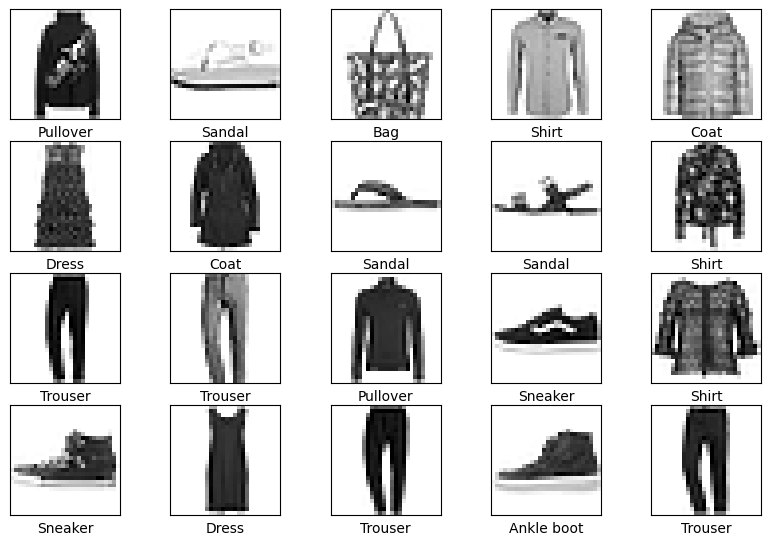

In [20]:
print('TRAIN IMAGES')
display(train_images, train_labels, labels_info, 20)

TEST IMAGES


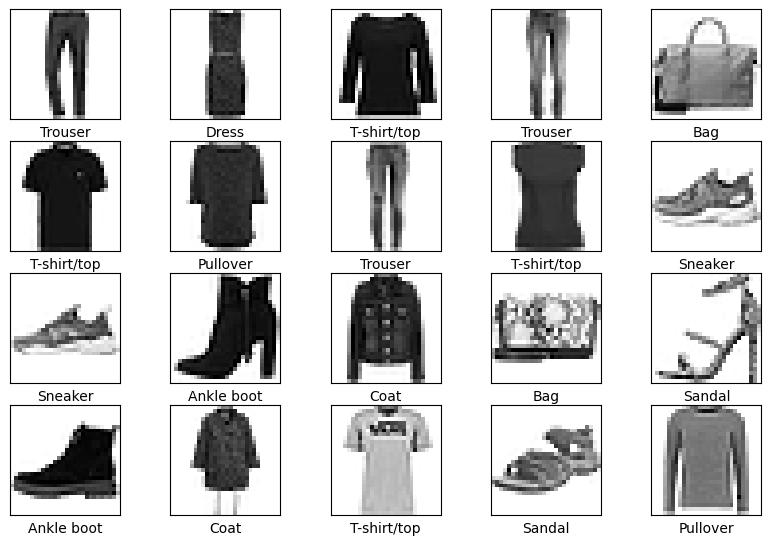

In [21]:
print('TEST IMAGES')
display(test_images, test_labels, labels_info, 20)

In [32]:
# from __future__ import print_function
# import time
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn import decomposition
# %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns
# features = ['pixel' + str(i+1) for i in range(traindata.shape[1]) ]
# pca_df = pd.DataFrame(traindata, columns=features)

# pca_df['label'] = train_labels
# pca_df = pca_df.drop('pixel785', axis=1)
# print('Size of the dataframe: {}'.format(pca_df.shape))
# pca_df.head()
# for i in range(pca_df.shape[0]):
